In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import open_dict
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from mldft.ml.data.components.convert_transforms import ToTorch
from mldft.ml.data.components.of_data import Representation
from mldft.ml.models.components.loss_function import (
    ImplicitLossFunction,
    project_gradient, EnergyLoss, EnergyGradientLoss, project_gradient_difference
)
from mldft.ml.models.mldft_module import MLDFTLitModule
from mldft.utils.instantiators import instantiate_datamodule

# auto reload magic
# %load_ext autoreload
# %autoreload 2

In [3]:
# os.environ["DFT_DATA"] = "/home/ladamowi/data"
os.environ["DFT_DATA"] = "/home/ladamowi/data_remote"

In [4]:
device = "cuda"

with initialize(version_base=None, config_path="../configs/ml"):
    config = compose(
        config_name="train.yaml",
        overrides=[
            "data/transforms=local_frames_global_natrep_add_lframes",
            "data=qm9",
            # "data.dataset_name=QM9_perturbed_fock_fixed",
            "data.dataset_name=QMUGSBin0QM9_perturbed_fock",
            "data.target_key=tot",
            "data.datamodule.batch_size=1",
            "data.datamodule.num_workers=8",
            "data.datamodule.shuffle_train=False",
            # "data.datamodule.split_file=/home/ladamowi/data/split_reduced_1.pkl"
            "data.datamodule.split_file=/home/ladamowi/data/split_1_alt.pkl"
        ],
    )

basis_info = instantiate(config.data.basis_info)

datamodule_config = config.data.datamodule.copy()
with open_dict(datamodule_config):
    datamodule_config.dataset_kwargs.additional_keys_at_scf_iteration = {
        "of_labels/spatial/grad_kin": Representation.GRADIENT,
        "of_labels/spatial/grad_xc": Representation.GRADIENT,
        "of_labels/spatial/grad_tot": Representation.GRADIENT,
        "of_labels/spatial/grad_kin_plus_xc": Representation.GRADIENT,
        "of_labels/energies/e_kin": Representation.SCALAR,
        "of_labels/energies/e_tot": Representation.SCALAR,
        "of_labels/energies/e_xc": Representation.SCALAR,
        "of_labels/energies/e_hartree": Representation.SCALAR,
        "of_labels/energies/e_ext": Representation.SCALAR,
        "of_labels/energies/e_electron": Representation.SCALAR,
        "ks_labels/energies/e_kin": Representation.SCALAR,
        "ks_labels/energies/e_tot": Representation.SCALAR,
        "ks_labels/energies/e_xc": Representation.SCALAR,
        "ks_labels/energies/e_hartree": Representation.SCALAR,
        "ks_labels/energies/e_ext": Representation.SCALAR,
        "ks_labels/energies/e_electron": Representation.SCALAR,
    }
    datamodule_config.dataset_kwargs.additional_keys_at_ground_state = {
        "of_labels/spatial/grad_kin": Representation.GRADIENT,
        "of_labels/spatial/grad_xc": Representation.GRADIENT,
        "of_labels/energies/e_electron": Representation.SCALAR,
        "of_labels/energies/e_ext": Representation.SCALAR,
        "of_labels/energies/e_hartree": Representation.SCALAR,
        "of_labels/energies/e_kin": Representation.SCALAR,
        "of_labels/energies/e_kin_plus_xc": Representation.SCALAR,
        "of_labels/energies/e_kin_minus_apbe": Representation.SCALAR,
        "of_labels/energies/e_kinapbe": Representation.SCALAR,
        "of_labels/energies/e_xc": Representation.SCALAR,
        "of_labels/energies/e_tot": Representation.SCALAR,
        "ks_labels/energies/e_kin": Representation.SCALAR,
        "ks_labels/energies/e_tot": Representation.SCALAR,
    }

datamodule = instantiate(datamodule_config)
datamodule.setup(stage="fit")

val_set = datamodule.val_set
train_set = datamodule.train_set

checkpoint_path1 = "/home/ladamowi/models/train/runs/e_tot_new/checkpoints/last.ckpt"
checkpoint_path2 = "/home/ladamowi/models/train/multiruns/eqvsjac/eq/checkpoints/last.ckpt" 
checkpoint_path3 = "/home/ladamowi/models/train/multiruns/eqvsjac/jac/checkpoints/last.ckpt"
checkpoints = [checkpoint_path1, checkpoint_path2, checkpoint_path3]
lg_modules = []
for k in checkpoints:
    mod = MLDFTLitModule.load_from_checkpoint(k, map_location=device).double()
    mod.net.deterministic = True
    mod.train()
    lg_modules.append(mod)
       
lightning_module1 = MLDFTLitModule.load_from_checkpoint(
    checkpoint_path1, map_location=device
).double()
lightning_module1.net.deterministic = True
lightning_module1.train()

lightning_module2 = MLDFTLitModule.load_from_checkpoint(
    checkpoint_path2, map_location=device
).double()
lightning_module2.net.deterministic = True
lightning_module2.train()

lightning_module3 = MLDFTLitModule.load_from_checkpoint(
    checkpoint_path3, map_location=device
).double()
lightning_module3.net.deterministic = True
lightning_module3.train()
# set default dtype to double
torch.set_default_dtype(torch.float64)

2025-08-25 14:58:09.624 | WARNING  | mldft.ml.data.components.basis_info:from_dataset_info_yaml:283 - The dataset info file was not found. Assuming that an even-tempered basis set with beta=2.5 was used.
2025-08-25 14:58:09.637 | WARNING  | mldft.ml.data.components.basis_info:from_dataset_info_yaml:283 - The dataset info file was not found. Assuming that an even-tempered basis set with beta=2.5 was used.
2025-08-25 14:58:09.660 | WARNING  | mldft.ml.data.components.basis_info:from_dataset_info_yaml:283 - The dataset info file was not found. Assuming that an even-tempered basis set with beta=2.5 was used.


In [5]:
iterate = iter(datamodule.train_dataloader())
batch = next(iterate)
batch = ToTorch(device=device)(batch)

In [7]:
fix_points = []
for net in lg_modules:
    fix_point_batch = batch.clone()
    fix_point_batch.coeffs = batch.ground_state_coeffs.clone()
    loss = torch.nn.MSELoss()
    impl_loss = ImplicitLossFunction(n_loops=2000, convergence_threshold_grad=1e-4,lr_grad = 2e-4)
    impl_loss.net = (net,)
    fp = fix_point_batch.clone()
    fp.coeffs = impl_loss.get_fixed_point(fp).clone()
    fix_points.append(fp.clone())

g_norm = 1.316e-02
g_norm = 1.261e-02
g_norm = 1.166e-02
g_norm = 1.055e-02
g_norm = 9.527e-03
g_norm = 8.777e-03
g_norm = 8.363e-03
g_norm = 8.193e-03
g_norm = 8.102e-03
g_norm = 7.948e-03
g_norm = 7.658e-03
g_norm = 7.230e-03
g_norm = 6.715e-03
g_norm = 6.187e-03
g_norm = 5.719e-03
g_norm = 5.358e-03
g_norm = 5.110e-03
g_norm = 4.946e-03
g_norm = 4.820e-03
g_norm = 4.696e-03
g_norm = 4.556e-03
g_norm = 4.397e-03
g_norm = 4.229e-03
g_norm = 4.065e-03
g_norm = 3.910e-03
g_norm = 3.768e-03
g_norm = 3.635e-03
g_norm = 3.508e-03
g_norm = 3.385e-03
g_norm = 3.265e-03
g_norm = 3.153e-03
g_norm = 3.051e-03
g_norm = 2.958e-03
g_norm = 2.873e-03
g_norm = 2.792e-03
g_norm = 2.711e-03
g_norm = 2.629e-03
g_norm = 2.546e-03
g_norm = 2.462e-03
g_norm = 2.382e-03
g_norm = 2.310e-03
g_norm = 2.246e-03
g_norm = 2.192e-03
g_norm = 2.146e-03
g_norm = 2.106e-03
g_norm = 2.067e-03
g_norm = 2.027e-03
g_norm = 1.985e-03
g_norm = 1.940e-03
g_norm = 1.893e-03
g_norm = 1.847e-03
g_norm = 1.803e-03
g_norm = 1.7

In [ ]:
# fix_point_batch = batch.clone()
# fix_point_batch.coeffs = batch.ground_state_coeffs.clone()
# loss = torch.nn.MSELoss()
# impl_loss = ImplicitLossFunction(n_loops=2000, convergence_threshold_grad=1e-4,lr_grad = 1e-3)
# impl_loss.net = (lightning_module1,)


In [ ]:
# fp1 = fix_point_batch.clone()
# print(fp1.coeffs)
# fp1.coeffs = impl_loss.get_fixed_point(fp1).clone()
# print(fp1.coeffs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
p0 = fix_point_batch.clone()
pr_batch = p0.clone()
net = lightning_module3
# Evaluate gradient at p0
_, grad_p0, _ = net(p0)  # Shape should match p0
# grad_direction = grad_p0 /torch.norm(grad_p0) # Normalize

# Define alpha range
alphas = np.linspace(-0.01, 0.01, 100)

# Compute energy and gradient norms along the line
energies = []
grad_norms = []
for alpha in alphas:
    pr_batch.coeffs = fp1.coeffs + alpha * grad_p0
    energy, grad,_ = net(pr_batch)
    
    energies.append(energy.detach().cpu().numpy())
    grad_norms.append(np.linalg.norm(grad.detach().cpu().numpy()))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(alphas, energies)
ax1.set_xlabel('α')
ax1.set_ylabel('E(w, p₀ + α∇E)')
ax1.set_title('Energy along gradient direction')
ax1.grid(True)

ax2.plot(alphas, grad_norms)
ax2.set_xlabel('α')
ax2.set_ylabel('||∇E(w, p₀ + α∇E)||')
ax2.set_title('Gradient norm along gradient direction')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [8]:
def compare_energy_gradients(p0_list, model_list, model_names, alpha_range=0.1, n_points=100, save_path=None):
    n_models = len(model_list)
    fig, axes = plt.subplots(2, n_models, figsize=(4*n_models, 8))
    
    for i, (p0, net, name) in enumerate(zip(p0_list, model_list, model_names)):
        # Get device from model and move p0 to same device
        device = next(net.parameters()).device
        p0 = p0.to(device)
        
        # Evaluate gradient at p0
        _, grad_p0, _ = net(p0)
        grad_p0 = grad_p0.detach().to(device)
        
        # Define alpha range
        alphas = np.linspace(-alpha_range, alpha_range, n_points)
        
        # Compute energy and gradient norms along the line
        energies = []
        grad_norms = []
        pr_batch = p0.clone().to(device)
        
        for alpha in alphas:
            pr_batch.coeffs = p0.coeffs.to(device) + alpha * grad_p0
            energy, grad, _ = net(pr_batch)
            
            energies.append(energy.detach().cpu().numpy())
            grad_norms.append(np.linalg.norm(grad.detach().cpu().numpy()))
        
        axes[0, i].plot(alphas, energies)
        axes[1, i].plot(alphas, grad_norms)
        
        axes[0, i].set_xlabel('α')
        axes[0, i].set_ylabel('E(w, p₀ + α∇E)')
        axes[0, i].set_title(f'{name} - Energy')
        axes[0, i].grid(True)
        
        axes[1, i].set_xlabel('α')
        axes[1, i].set_ylabel('||∇E(w, p₀ + α∇E)||')
        axes[1, i].set_title(f'{name} - Gradient Norm')
        axes[1, i].grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

In [9]:
p0s = fix_points
models = [lightning_module1, lightning_module2, lightning_module3]
model_names = ['Pre-trained', "EQPROP", "Jacobian"]

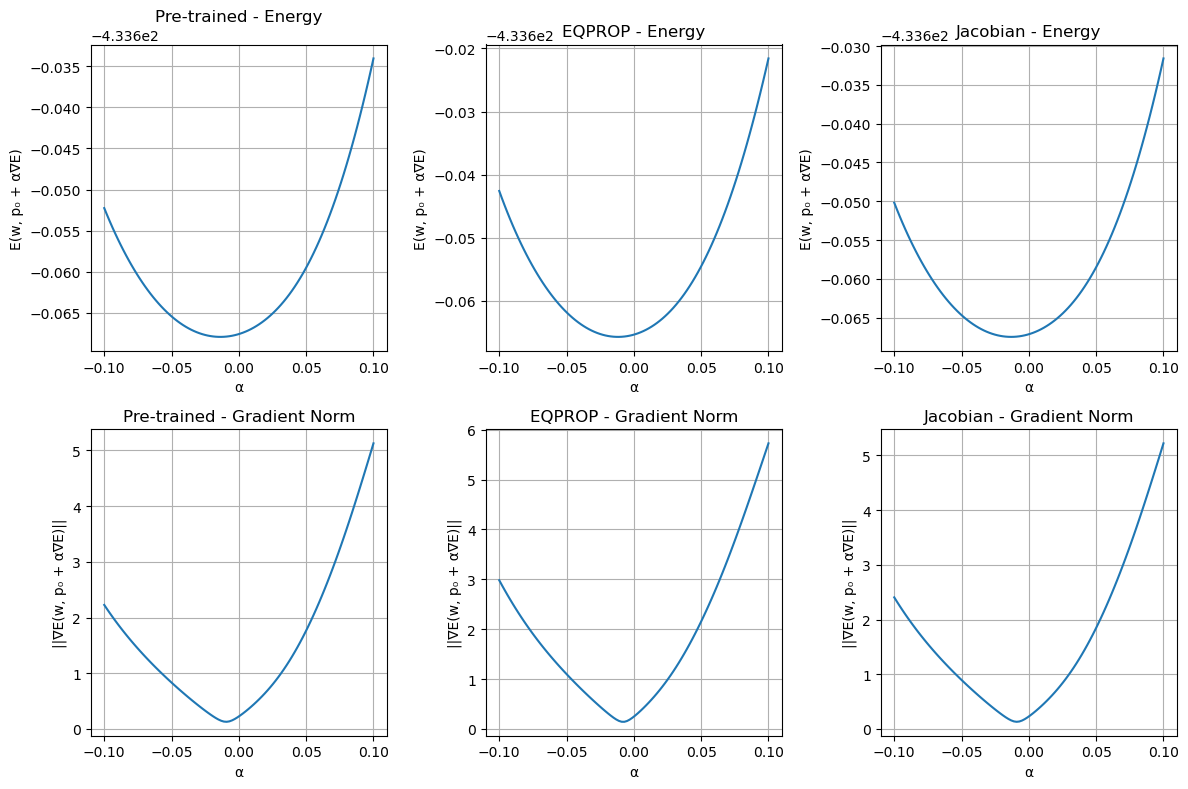

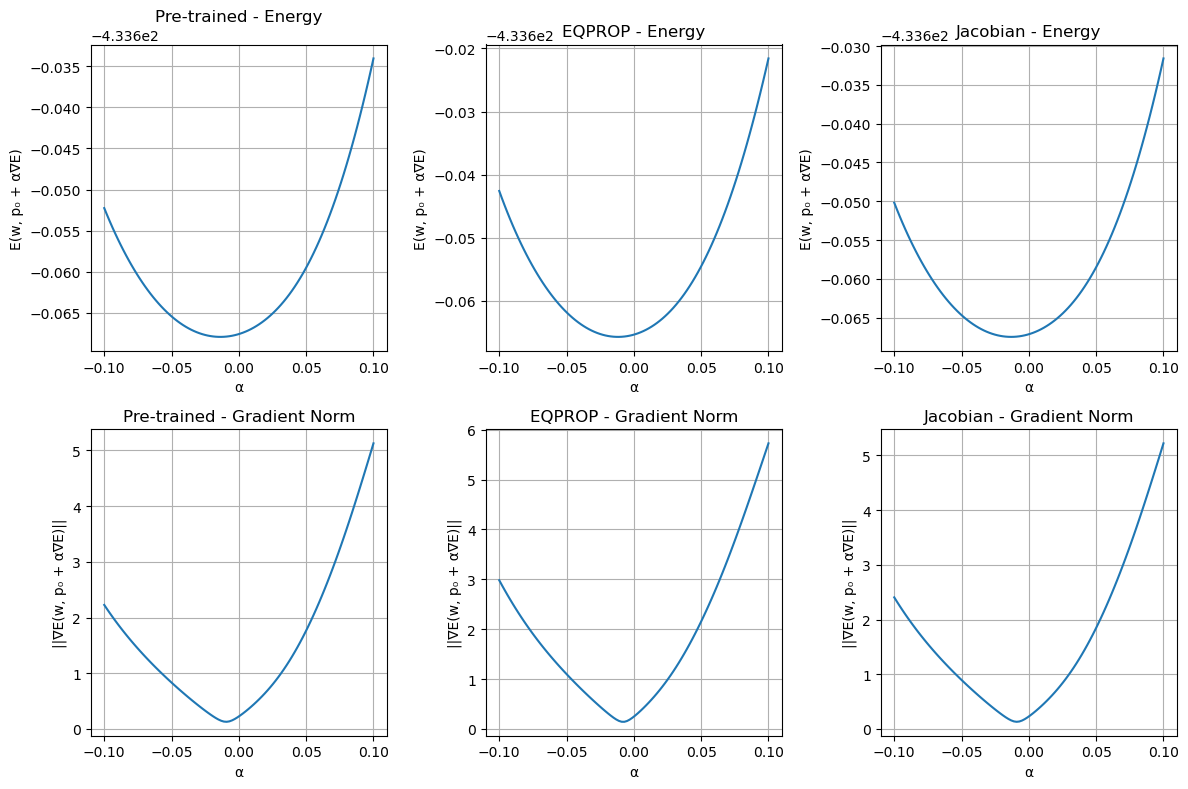

In [10]:
compare_energy_gradients(p0s, models, model_names, save_path=None)